In [11]:
import pandas as pd
import numpy as np
from datetime import datetime

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

In [13]:
# Modelado y Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_statsmodels import backtesting_sarimax
from skforecast.model_selection_statsmodels import grid_search_sarimax

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_percentage_error

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
# transformamos los datos a formato fecha para poder trabajar con un modelo de time series
data = pd.read_csv('C:/Users/Joni/Desktop/last_work/users_web.csv')
data['Date'] = pd.to_datetime(data['Date'],format='%d/%m/%Y')
data.tail()

,Date,Users
846,2022-04-26,63
847,2022-04-27,64
848,2022-04-28,46
849,2022-04-29,29
850,2022-04-30,21


In [16]:
data = data.set_index('Date')
data = data.asfreq('1D')
data = data.sort_index()
data.head()

,Users
Date,
2020-01-01,13
2020-01-02,17
2020-01-03,13
2020-01-04,4
2020-01-05,10


In [17]:
data.tail()

,Users
Date,
2022-04-26,63
2022-04-27,64
2022-04-28,46
2022-04-29,29
2022-04-30,21


In [18]:
# comprobamos que todos los datos se han transformado como índice
(data.index == pd.date_range(
                    start = data.index.min(),
                    end   = data.index.max(),
                    freq  = data.index.freq)
                ).all()

True

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 851 entries, 2020-01-01 to 2022-04-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Users   851 non-null    int64
dtypes: int64(1)
memory usage: 13.3 KB


In [20]:
data

,Users
Date,
2020-01-01,13
2020-01-02,17
2020-01-03,13
2020-01-04,4
2020-01-05,10
...,...
2022-04-26,63
2022-04-27,64
2022-04-28,46


In [21]:
# Rango del dataset
print('El dataset empieza el día {} y acaba el día {}'.format(data.index.min().date(), data.index.max().date()))

El dataset empieza el día 2020-01-01 y acaba el día 2022-04-30


In [22]:
# Separamos los datos en train, validación y test

datos_train = data.iloc[:509,:]
datos_val = data.iloc[509:680,:]
datos_test = data.iloc[680:,:]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas val      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2020-01-01 00:00:00 --- 2021-05-23 00:00:00  (n=509)
Fechas val      : 2020-01-01 00:00:00 --- 2021-05-23 00:00:00  (n=171)
Fechas test       : 2021-11-11 00:00:00 --- 2022-04-30 00:00:00  (n=171)


In [23]:
datos_test.to_csv("datos_test.csv")

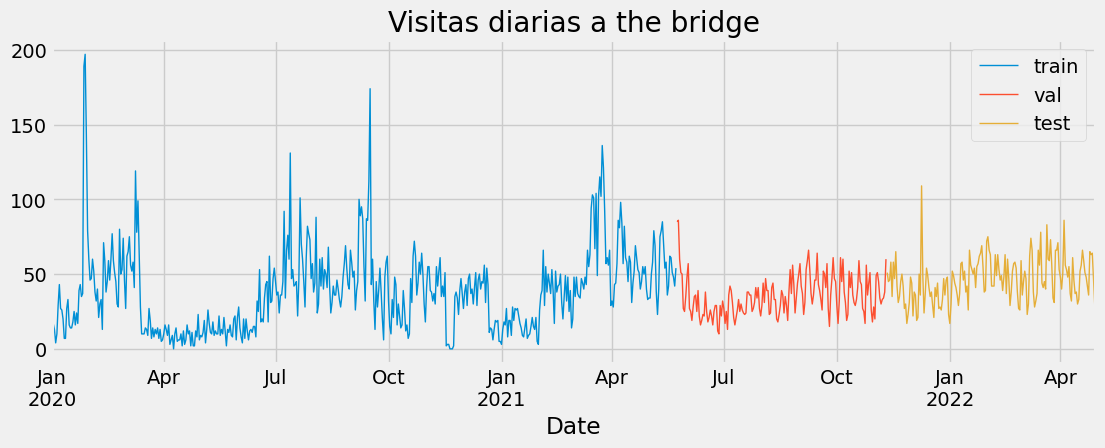

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.Users.plot(ax=ax, label='train', linewidth=1)
datos_val.Users.plot(ax=ax, label='val', linewidth=1)
datos_test.Users.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Visitas diarias a the bridge')
ax.legend();

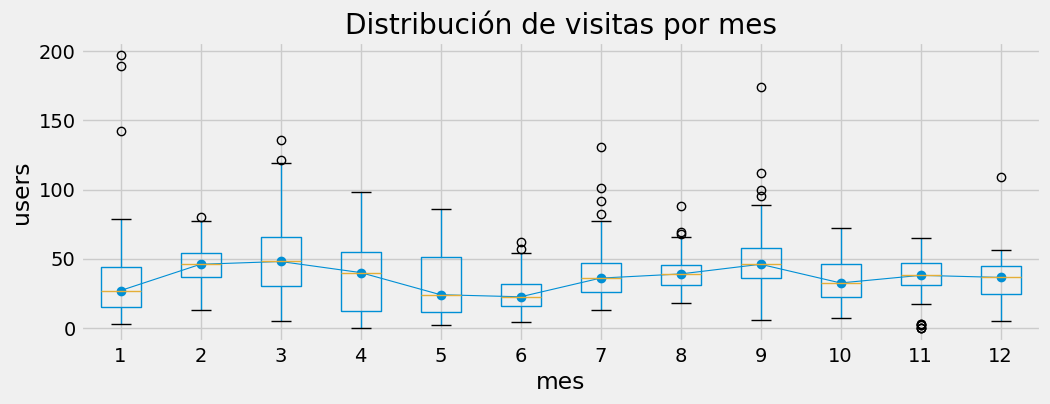

In [25]:
fig, ax = plt.subplots(figsize=(12,4))
data['mes'] = data.index.month
data.boxplot(column='Users', by='mes', ax=ax,)
data.groupby('mes')['Users'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('users')
ax.set_title('Distribución de visitas por mes')
fig.suptitle('');

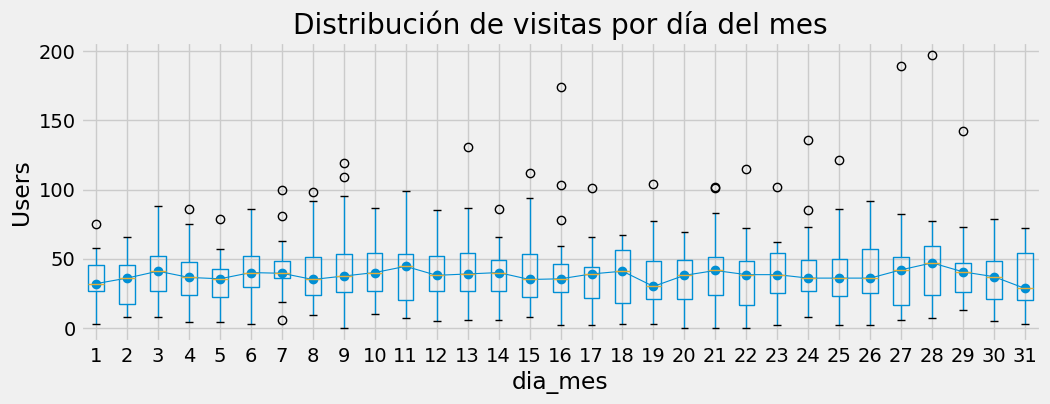

In [26]:
fig, ax = plt.subplots(figsize=(12,4))
data['dia_mes'] = pd.Series(data.index).dt.day.values
data.boxplot(column='Users', by='dia_mes', ax=ax,)
data.groupby('dia_mes')['Users'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Users')
ax.set_title('Distribución de visitas por día del mes')
fig.suptitle('');

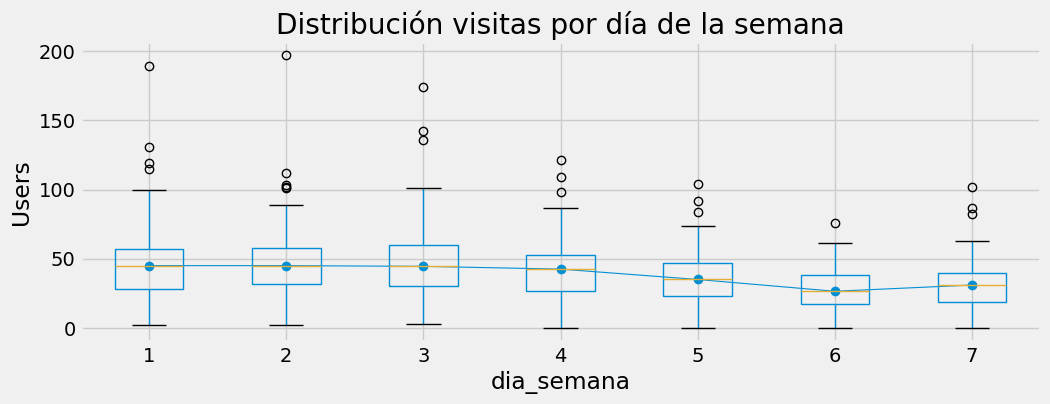

In [27]:
fig, ax = plt.subplots(figsize=(12,4))
data['dia_semana'] = data.index.day_of_week + 1
data.boxplot(column='Users', by='dia_semana', ax=ax)
data.groupby('dia_semana')['Users'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Users')
ax.set_title('Distribución visitas por día de la semana')
fig.suptitle('');

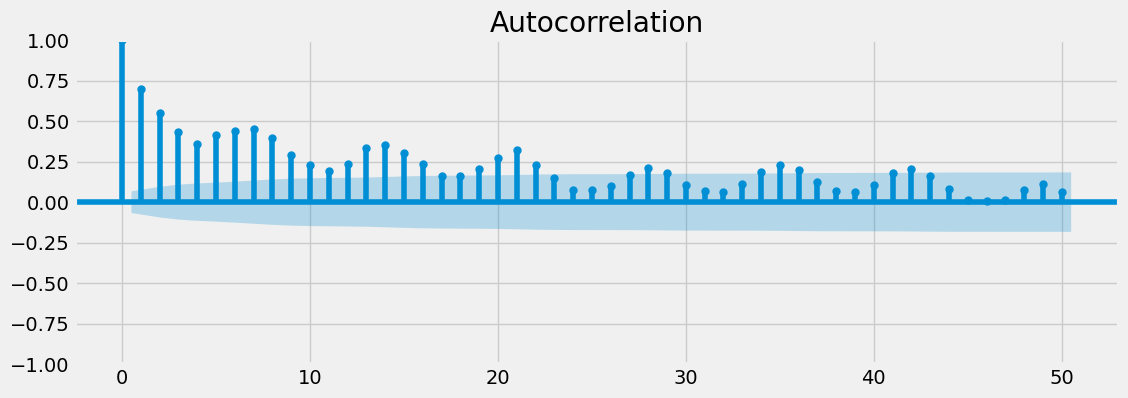

In [28]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(data.Users, ax=ax, lags=50);

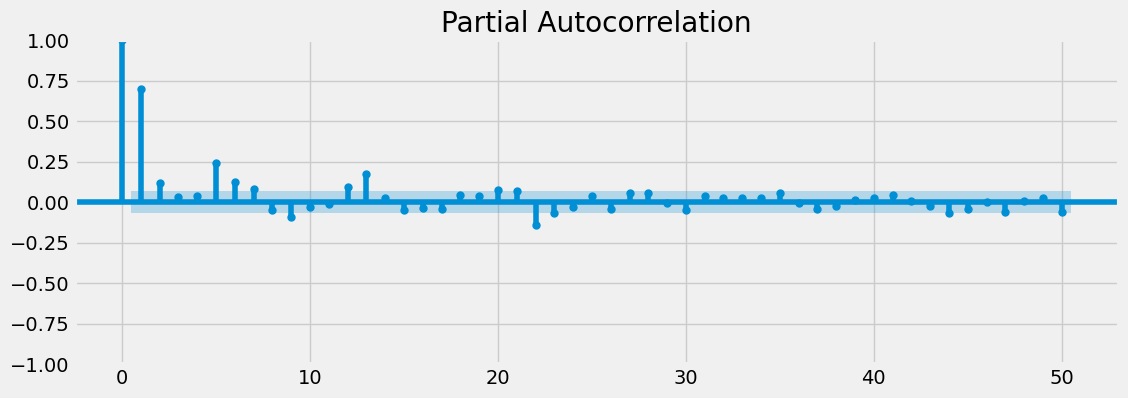

In [29]:
fig, ax = plt.subplots(figsize=(12,4))
plot_pacf(data.Users, ax=ax, lags=50);

In [30]:
# Crear y entrenar forecaster
# ==============================================================================

# NO TOCAR XFABO
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=42),
                 lags          = 90, # los ultimos valores que queremos usar para predecir
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=datos_train.Users)
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 90 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-01-01 00:00:00'), Timestamp('2021-05-23 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-12-18 16:03:23 
Last fit date: 2022-12-18 16:03:23 
Skforecast version: 0.6.0 
Python versi

In [31]:
# Backtest
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data.Users,
                            initial_train_size = len(datos_train+datos_val),
                            steps              = 30, #salto en el tiempo, 30 son 30 dias
                            refit              = True,
                            fixed_train_size   = True,
                            metric             = 'mean_absolute_percentage_error',
                            verbose            = True
                        )

print(f'Error backtest: {round(metrica*100,2)}%')
predicciones.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 680
Number of observations used for backtesting: 171
    Number of folds: 6
    Number of steps per fold: 30
    Last fold only includes 21 observations.

Data partition in fold: 0
    Training:   2020-01-01 00:00:00 -- 2021-11-10 00:00:00  (n=680)
    Validation: 2021-11-11 00:00:00 -- 2021-12-10 00:00:00  (n=30)
Data partition in fold: 1
    Training:   2020-01-31 00:00:00 -- 2021-12-10 00:00:00  (n=680)
    Validation: 2021-12-11 00:00:00 -- 2022-01-09 00:00:00  (n=30)
Data partition in fold: 2
    Training:   2020-03-01 00:00:00 -- 2022-01-09 00:00:00  (n=680)
    Validation: 2022-01-10 00:00:00 -- 2022-02-08 00:00:00  (n=30)
Data partition in fold: 3
    Training:   2020-03-31 00:00:00 -- 2022-02-08 00:00:00  (n=680)
    Validation: 2022-02-09 00:00:00 -- 2022-03-10 00:00:00  (n=30)
Data partition in fold: 4
    Training:   2020-04-30 00:00:00 -- 2022-03-10 00:00

,pred
2021-11-11,46.234338
2021-11-12,36.558931
2021-11-13,30.470697
2021-11-14,22.575412
2021-11-15,43.655509


In [32]:
predicciones.index = datos_test.index
predicciones.head()

,pred
Date,
2021-11-11,46.234338
2021-11-12,36.558931
2021-11-13,30.470697
2021-11-14,22.575412
2021-11-15,43.655509


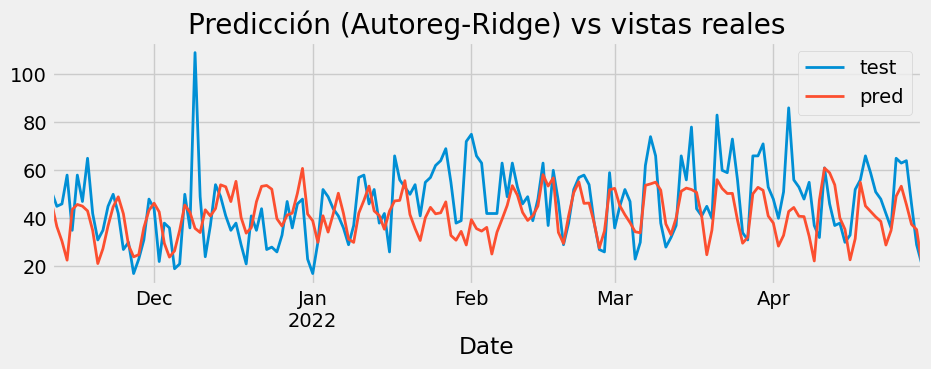

In [33]:
fig, ax = plt.subplots(figsize=(10, 3))
datos_test.loc[predicciones.index, 'Users'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción (Autoreg-Ridge) vs vistas reales')
ax.legend();


In [34]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=42),
                 lags          = 90,
                 transformer_y = StandardScaler()
             )

# Hiperparámetros del regresor
param_grid = {'alpha': range(-100,100, 10)}

# Lags utilizados como predictores
lags_grid = [60, 90, 120, [60, 90, 120]]

resultados_grid = grid_search_forecaster(
                      forecaster         = forecaster,
                      y                  = data.iloc[:680]['Users'],
                      param_grid         = param_grid,
                      lags_grid          = lags_grid,
                      steps              = 30,
                      metric             = 'mean_absolute_percentage_error',
                      refit              = True,
                      initial_train_size = len(datos_train),
                      fixed_train_size   = True,
                      return_best        = True,
                      verbose            = False
                  )

Number of models compared: 80.


loop lags_grid:   0%|                                               | 0/4 [00:00<?, ?it/s]


ValueError: alpha == -100, must be >= 0.0.

In [ ]:
from lightgbm import LGBMRegressor # version mas potente de gradient boosting

In [ ]:
# Crear y entrenar segundo forecaster 
# ==============================================================================

forecast_2 = ForecasterAutoreg(
                 regressor     = LGBMRegressor(max_depth=2, learning_rate=0.1, n_estimators=50, random_state=42),
                 lags          = 90, # los ultimos valores que queremos usar para predecir
             )

forecast_2.fit(y=data.iloc[:680]['Users'])
forecast_2

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=2, n_estimators=50, random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90] 
Transformer for y: None 
Transformer for exog: None 
Window size: 90 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-01-01 00:00:00'), Timestamp('2021-11-10 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_lea

In [ ]:
preds_2 = forecast_2.predict(steps=30)
preds_2

2021-11-11    44.123464
2021-11-12    36.768932
2021-11-13    29.551561
2021-11-14    30.119171
2021-11-15    37.502216
2021-11-16    44.656914
2021-11-17    46.892388
2021-11-18    41.863916
2021-11-19    35.596273
2021-11-20    30.102976
2021-11-21    31.650023
2021-11-22    35.943749
2021-11-23    45.310309
2021-11-24    47.590601
2021-11-25    43.108878
2021-11-26    35.128871
2021-11-27    29.965028
2021-11-28    30.918476
2021-11-29    35.800036
2021-11-30    45.908776
2021-12-01    47.746806
2021-12-02    40.274996
2021-12-03    35.685990
2021-12-04    29.965028
2021-12-05    30.478398
2021-12-06    37.402030
2021-12-07    44.744254
2021-12-08    49.638887
2021-12-09    41.113341
2021-12-10    37.538000
Freq: D, Name: pred, dtype: float64

In [ ]:
# Backtest
# ==============================================================================
metrica, preds_2 = backtesting_forecaster(
                            forecaster         = forecast_2,
                            y                  = data.Users,
                            initial_train_size = len(datos_train+datos_val),
                            steps              = 30, #salto en el tiempo, 30 son 30 dias
                            refit              = True,
                            fixed_train_size   = True,
                            metric             = 'mean_absolute_percentage_error',
                            verbose            = True
                        )

print(f'Error backtest: {round(metrica*100,2)}%')
preds_2.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 680
Number of observations used for backtesting: 171
    Number of folds: 6
    Number of steps per fold: 30
    Last fold only includes 21 observations.

Data partition in fold: 0
    Training:   2020-01-01 00:00:00 -- 2021-11-10 00:00:00  (n=680)
    Validation: 2021-11-11 00:00:00 -- 2021-12-10 00:00:00  (n=30)
Data partition in fold: 1
    Training:   2020-01-31 00:00:00 -- 2021-12-10 00:00:00  (n=680)
    Validation: 2021-12-11 00:00:00 -- 2022-01-09 00:00:00  (n=30)
Data partition in fold: 2
    Training:   2020-03-01 00:00:00 -- 2022-01-09 00:00:00  (n=680)
    Validation: 2022-01-10 00:00:00 -- 2022-02-08 00:00:00  (n=30)
Data partition in fold: 3
    Training:   2020-03-31 00:00:00 -- 2022-02-08 00:00:00  (n=680)
    Validation: 2022-02-09 00:00:00 -- 2022-03-10 00:00:00  (n=30)
Data partition in fold: 4
    Training:   2020-04-30 00:00:00 -- 2022-03-10 00:00

,pred
2021-11-11,44.123464
2021-11-12,36.768932
2021-11-13,29.551561
2021-11-14,30.119171
2021-11-15,37.502216


In [ ]:
preds_2.index = datos_test.index
preds_2.head()

,pred
Date,
2021-11-11,44.123464
2021-11-12,36.768932
2021-11-13,29.551561
2021-11-14,30.119171
2021-11-15,37.502216


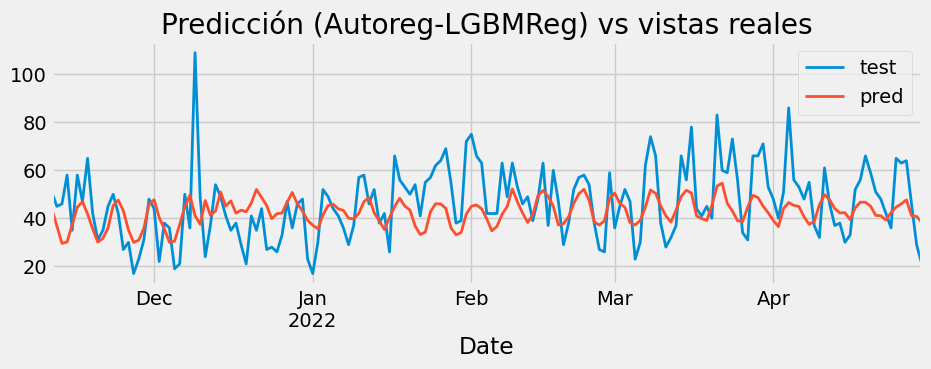

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
datos_test.loc[preds_2.index, 'Users'].plot(ax=ax, linewidth=2, label='test')
preds_2.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción (Autoreg-LGBMReg) vs vistas reales')
ax.legend();

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10, 15],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [50, 60, 90, 120, [50, 60, 90, 120,]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecast_2,
                        y                  = data.iloc[:680]['Users'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 30,
                        refit              = True,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(datos_train)),
                        return_best        = True,
                        verbose            = False)

Number of models compared: 80.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [01:42<00:00, 20.54s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 0.25131706222185995



In [ ]:
resultados_grid

,lags,params,mean_absolute_percentage_error,learning_rate,max_depth,n_estimators
53,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.251317,0.01,10.0,500.0
60,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.263299,0.10,10.0,100.0
62,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 15, 'n_est...",0.265632,0.10,15.0,100.0
61,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.265656,0.10,10.0,500.0
42,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.266369,0.10,5.0,100.0
...,...,...,...,...,...,...
74,"[50, 60, 90, 120]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.487243,0.10,5.0,100.0
73,"[50, 60, 90, 120]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.499588,0.10,3.0,500.0
79,"[50, 60, 90, 120]","{'learning_rate': 0.1, 'max_depth': 15, 'n_est...",0.516186,0.10,15.0,500.0
77,"[50, 60, 90, 120]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.519302,0.10,10.0,500.0


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecast_RF = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=42),
                lags = 90
             )

forecast_RF.fit(y=data.iloc[:680]['Users'])
forecast_RF

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90] 
Transformer for y: None 
Transformer for exog: None 
Window size: 90 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-01-01 00:00:00'), Timestamp('2021-11-10 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimator

In [ ]:
preds_3 = forecast_RF.predict(steps=30)
preds_3

2021-11-11    41.18
2021-11-12    34.23
2021-11-13    28.05
2021-11-14    28.35
2021-11-15    36.07
2021-11-16    44.39
2021-11-17    43.20
2021-11-18    40.92
2021-11-19    33.51
2021-11-20    29.44
2021-11-21    29.09
2021-11-22    38.81
2021-11-23    44.05
2021-11-24    46.65
2021-11-25    39.26
2021-11-26    30.93
2021-11-27    25.86
2021-11-28    26.74
2021-11-29    37.05
2021-11-30    42.52
2021-12-01    43.33
2021-12-02    38.50
2021-12-03    30.34
2021-12-04    24.53
2021-12-05    25.55
2021-12-06    32.45
2021-12-07    44.73
2021-12-08    46.83
2021-12-09    38.36
2021-12-10    30.02
Freq: D, Name: pred, dtype: float64

In [ ]:
# Backtest
# ==============================================================================
metrica, preds_3 = backtesting_forecaster(
                            forecaster         = forecast_RF,
                            y                  = data.Users,
                            initial_train_size = len(datos_train+datos_val),
                            steps              = 30, #salto en el tiempo, 30 son 30 dias
                            refit              = True,
                            fixed_train_size   = True,
                            metric             = 'mean_absolute_percentage_error',
                            verbose            = True
                        )

print(f'Error backtest: {round(metrica*100,2)}%')
preds_3.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 680
Number of observations used for backtesting: 171
    Number of folds: 6
    Number of steps per fold: 30
    Last fold only includes 21 observations.

Data partition in fold: 0
    Training:   2020-01-01 00:00:00 -- 2021-11-10 00:00:00  (n=680)
    Validation: 2021-11-11 00:00:00 -- 2021-12-10 00:00:00  (n=30)
Data partition in fold: 1
    Training:   2020-01-31 00:00:00 -- 2021-12-10 00:00:00  (n=680)
    Validation: 2021-12-11 00:00:00 -- 2022-01-09 00:00:00  (n=30)
Data partition in fold: 2
    Training:   2020-03-01 00:00:00 -- 2022-01-09 00:00:00  (n=680)
    Validation: 2022-01-10 00:00:00 -- 2022-02-08 00:00:00  (n=30)
Data partition in fold: 3
    Training:   2020-03-31 00:00:00 -- 2022-02-08 00:00:00  (n=680)
    Validation: 2022-02-09 00:00:00 -- 2022-03-10 00:00:00  (n=30)
Data partition in fold: 4
    Training:   2020-04-30 00:00:00 -- 2022-03-10 00:00

,pred
2021-11-11,41.18
2021-11-12,34.23
2021-11-13,28.05
2021-11-14,28.35
2021-11-15,36.07


In [ ]:
print(f'Error backtest: {round(metrica*100,2)}%')

Error backtest: 24.51%


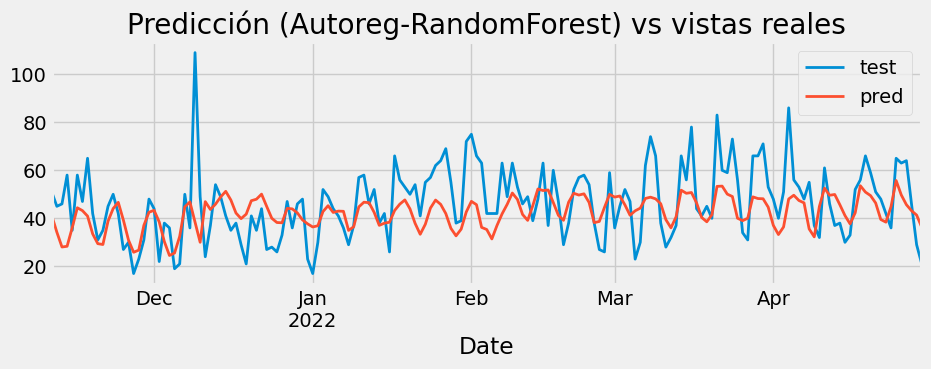

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
datos_test.loc[preds_3.index, 'Users'].plot(ax=ax, linewidth=2, label='test')
preds_3.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción (Autoreg-RandomForest) vs vistas reales')
ax.legend();

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
# Lags utilizados como predictores
lags_grid = [60, 90, 120, 180]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [3, 5, 10, 15, None, 20]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecast_RF,
                        y                  = data.iloc[:680]['Users'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 30,
                        refit              = True,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(datos_train)),
                        return_best        = True,
                        verbose            = False)

Number of models compared: 72.


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [48:23<00:00, 725.79s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120] 
  Parameters: {'max_depth': None, 'n_estimators': 100}
  Backtesting metric: 0.3252795673264962

